<a href="https://colab.research.google.com/github/deepakmeena61/Image-Colorisation/blob/main/image_colorisation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Image Colorisation using U-Net and GAN

Baseline model: It is approaching the problem as classification task but there are some uncertainities. So, I approached the question using linear regression by doing a few more tweaks.
But I am going to use a different strategy.

I am going to use the pix2pix strategy for Image coolorisation, which suggests those images not only learn maping but they also learn a loss function to train this mapping. This is a better approach with less dataset and better results.

- Installing libraries

In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds
import numpy as np
import glob
import matplotlib.pyplot as plt
from PIL import Image
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from skimage.color import rgb2lab, lab2rgb

- Preparing the dataset

In [19]:
#!pip install fastai==2.4

In [2]:
from fastai.data.external import untar_data, URLs
coco_path = untar_data(URLs.COCO_SAMPLE)
coco_path = str(coco_path) + "/train_sample"

- Selecting a portion consisting 15000 images out of the COCO dataset

In [3]:
paths = glob.glob(coco_path + "/*.jpg") # Getting all the image file names
np.random.seed(123)
paths_subset = np.random.choice(paths, 15000, replace=False) # Selecting 15000 images randomly
rand_idxs = np.random.permutation(15000)
train = paths_subset[rand_idxs[:10000]] # Selecting 10000 images for training set
valid = paths_subset[rand_idxs[10000:12500]] # Selecting 2500 images for validation set
test = paths_subset[rand_idxs[12500:]] # Selecting 2500 images for training set
print(len(train), len(valid), len(test))

10000 2500 2500


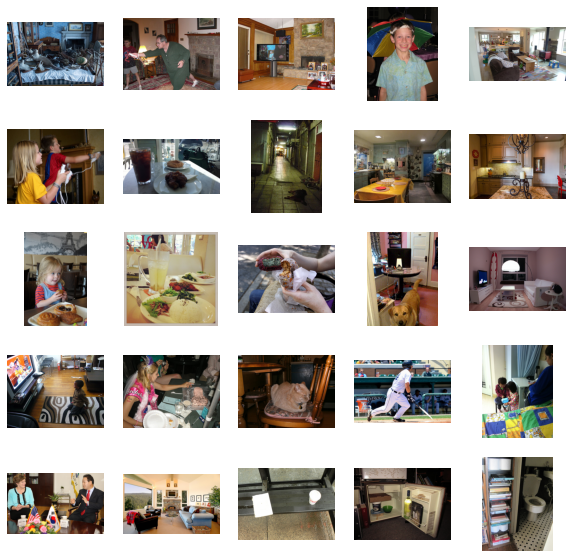

In [4]:
_, axes = plt.subplots(5, 5, figsize=(10, 10))
for ax, img_samples in zip(axes.flatten(), train):
    ax.imshow(Image.open(img_samples))
    ax.axis("off")

- Making dataset by resizing the images and flipping horizontally(only train) and then reas an RGB image. Further, converting it to L*a*b color space and separating the grayscale(L) channel and the color channel as inputs and outputs respectively.

Data augmentation increases the number of examples in the training dataset while also introducing more variety in what the model sees and learns from. This makes difficult for model to simply memorize mappings simultaneously, encouraging model to learn general patterns.

This can be achieved by doing simple geometric transformations, such as flipping, rotating, cropping or translating the images.

Bicubic interpolation preserves the fine details better by considering 4x4 pixels around it unlike bilinear. This increases the accuracy of the model.

In [5]:
class MakingDataset(Dataset):
  def __init__(self, location, dset = 'train'):
    self.dset = dset
    self.location = location
    self.size = 256

    if dset == 'train':
      self.transform = transforms.Compose([transforms.Resize((self.size, self.size), Image.BICUBIC),
                                            transforms.RandomHorizontalFlip()]) # Data Augmentation
    elif dset == 'valid':
      self.transform = transforms.Resize((self.size, self.size), Image.BICUBIC)

    elif dset == 'test':
      self.transform = transforms.Resize((self.size, self.size), Image.BICUBIC)
    
  def __getitem__(self, index):
    picture = Image.open(self.location[index]).convert("RGB")
    picture = self.transform(picture)
    picture = np.array(picture)
    rgb_lab = rgb2lab(picture).astype("float32") # Converting RGB to L*a*b
    rgb_lab = transforms.ToTensor()(rgb_lab)
    L = rgb_lab[[0], ...]/50. - 1. # Between -1 and 1
    ab = rgb_lab[[1,2], ...]/110. # Betweem -1 and 1

    return {'L':L, 'ab':ab}
  
  def __len__(self):
    return len(self.location)
  
def create_dataloader(batch_size = 16, n_workers = 2, pin_memory = True, **kwargs):
  dataset = MakingDataset(**kwargs)
  dataloader = DataLoader(dataset, batch_size = batch_size, num_workers = n_workers, pin_memory = pin_memory)
  return dataloader

In [6]:
train_dl = create_dataloader(location=train, dset='train')
valid_dl = create_dataloader(location=valid, dset='valid')
test_dl = create_dataloader(location=test, dset='test')

data = next(iter(train_dl))
Ls, abs_ = data['L'], data['ab']
print(Ls.shape, abs_.shape)
print(len(train_dl), len(valid_dl), len(test_dl))

/usr/local/lib/python3.7/dist-packages/torchvision/transforms/transforms.py:333: UserWarning: Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. Please use InterpolationMode enum.
  "Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. "


torch.Size([16, 1, 256, 256]) torch.Size([16, 2, 256, 256])
625 157 157


- Creating Generator